In [0]:
import numpy as np
import pystan
from scipy import stats
import matplotlib.pyplot as plt
import pandas
import seaborn
import math

In [0]:
#The CSV needs to be manually uploaded to the files section on the left
#Or be imported from google drive via a drive mounting command

#Load the data and discard the first 44 rows of text
data = np.loadtxt('weekly_in_situ_co2_mlo.csv', 
                  skiprows = 44, dtype = object )
#Converting the CO2 column into floats
data[:, 1] = data[:, 1].astype('float')

In [0]:
#Converting the date column into days so we can use it to represent time
from datetime import datetime

#Let the reference day be 0
ref = datetime.strptime(str(data[0,0]), '%Y-%m-%d,')

for i, date in enumerate(data[:, 0]):
  a = datetime.strptime(str(date), '%Y-%m-%d,')
  day_delta = a - ref
  data[i, 0] = int(day_delta.days)

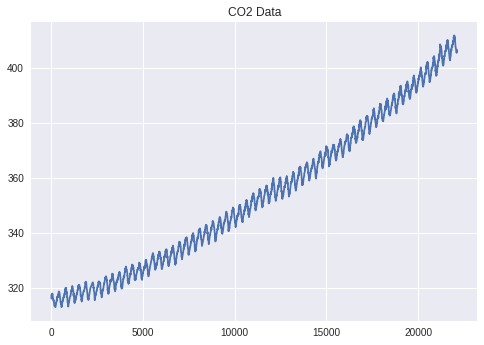

In [0]:
#Plotting the data for observation
plt.plot(data[:,0], data[:,1])
plt.title('CO2 Data')
plt.show()

In [0]:
#The stan data
n = data.shape[0]
t = data[:n, 0].tolist()       
x = data[:n, 1].tolist()
n_future = 40*52 #the time between 2018-2058 in weeks
        
#The Stan Model
stan_data = {
    'n': n, #number of datapoints in the data
    'n_future': n_future, #number of datapoints to predict
    'future': np.max(t) + 1, #the starting point of the future
    'x': x, #the real data 
    't': t, #the number of days
    } 

In [0]:
stan_code = """
data {
    int<lower=0> n;         
    real x[n];       
    int<lower=0> future;
    int<lower=0> n_future;  
    int<lower=0> t[n];
}

parameters {
    real<lower=0> c0; // intercept
    real<lower=0, upper=5> A; // amplitude
    real<lower=-pi(), upper=pi()> phi; // phase shift    
    real<lower=0> c2; // cubic
    real c1_s; //slope before transformation
    real sigma_s; //noise before transformation
}

transformed parameters {    
    real<lower=0> c1; // slope after transformation   
    real<lower=0> sigma; // noise after transformation   
    
    //exponential transformation to make sampling more efficent
    c1 = exp(c1_s); 
    sigma = exp(sigma_s);
}

model {
    c0 ~ normal(315, 10);
    A ~ normal(2.5, 0.5);
    c2 ~ normal(0.01, 0.01);
    phi ~ normal(0, 3.5);
    
    c1_s ~ normal(-5, 1); // Priors chosen to yield small positive numbers
    sigma_s ~ normal(-1, 1);

    for(i in 1:n) {
        x[i] ~ normal(
                          
            c0 + c1*t[i] + c2*t[i]^2 + A * cos(2*pi()*t[i]/365.25 + phi), sigma);
            //Assuming the period to be a year which is 365.25 days
    }
}   

generated quantities {
    real x_future[n_future];
    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            c0 + c1*(future+i*7) + c2*(future+i*7)^2 + A*cos(2*pi()*(future+i*7)/365.25 + phi), 
            sigma);
            //it's i*7 because the x_future is the number of weeks till 2058
    }   
}

"""
    
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a51c64a902cfe9daec2bfafd4afbd5ad NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpuqvwuoea/stanfit4anon_model_a51c64a902cfe9daec2bfafd4afbd5ad_7223893146031565007.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
#parameters of interest
parameters = ['c0', 'c1', 'c2', 'A', 'phi', 'sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_a51c64a902cfe9daec2bfafd4afbd5ad.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0     314.5  1.1e-3   0.05  314.4 314.47  314.5 314.54 314.61   2455    1.0
c1    2.1e-3  2.4e-7 1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.2e-3   2033    1.0
c2    9.6e-8 1.0e-114.7e-10 9.5e-8 9.5e-8 9.6e-8 9.6e-8 9.7e-8   2061    1.0
A       2.86  4.8e-4   0.03   2.81   2.84   2.86   2.87   2.91   2832    1.0
phi    -0.42  1.6e-4 8.5e-3  -0.43  -0.42  -0.42  -0.41   -0.4   2838    1.0
sigma   0.97  2.2e-4   0.01   0.95   0.96   0.97   0.98    1.0   2922    1.0

Samples were drawn using NUTS at Mon Dec 17 23:12:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


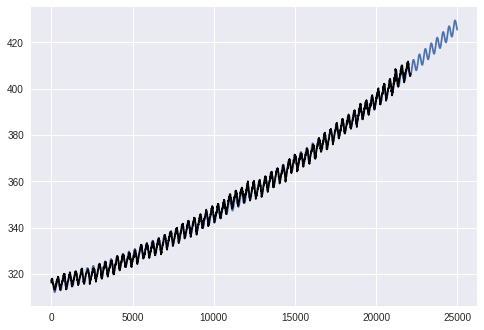

In [0]:
#Use this to check the results and adjust the parameters and priors
c0 = samples['c0'].mean()
c1 = samples['c1'].mean()
c2 = samples['c2'].mean()
A = samples['A'].mean()
phi = samples['phi'].mean()
sigma = samples['sigma'].mean()

x = np.linspace(1, 25000,25000)
y = c0 + c1*(x) + c2*(x)**2 + A * np.cos(2*math.pi*(x)/365.25 + phi)

plt.plot(x, y)
plt.plot(data[:, 0], data[:, 1], 'k-')

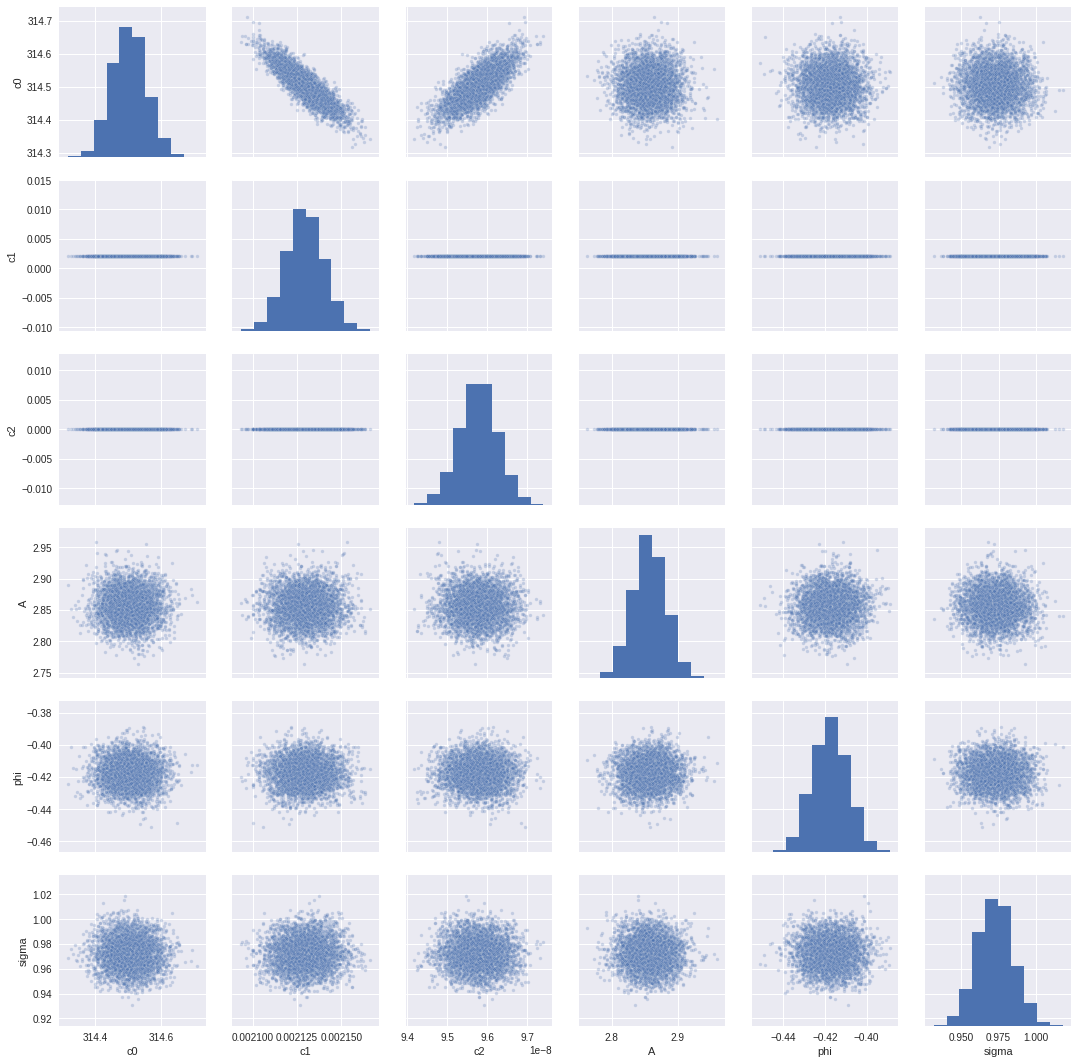

In [0]:
# Make pair plot of the posteriors over all the parameters
# Code reference: 14.1 Preclass work 3
df = pandas.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

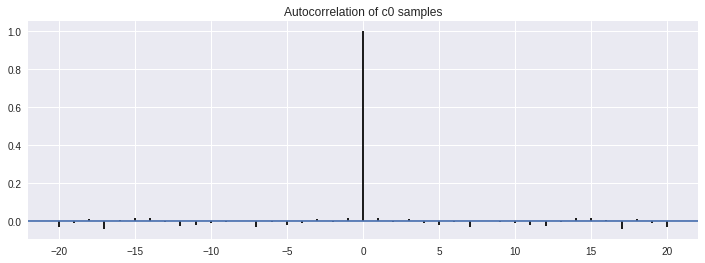

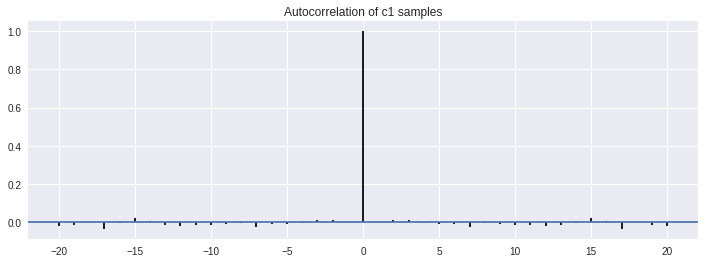

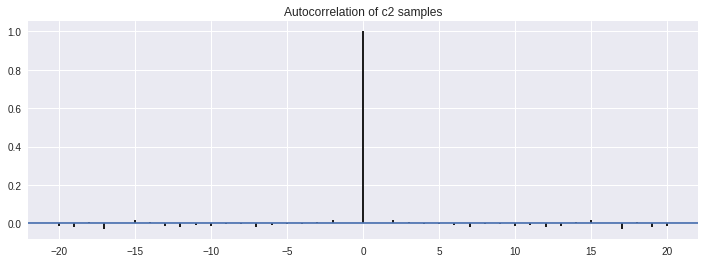

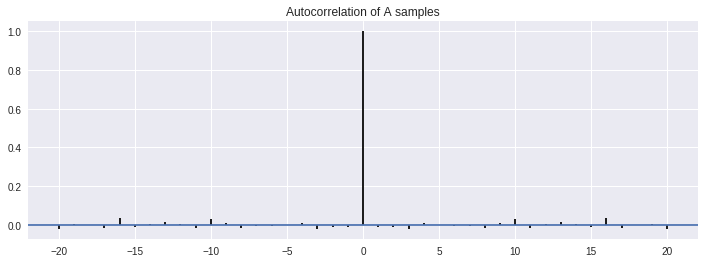

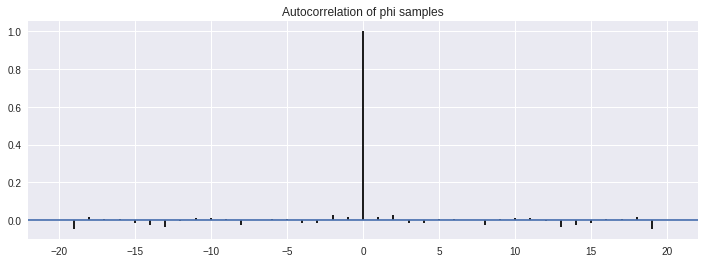

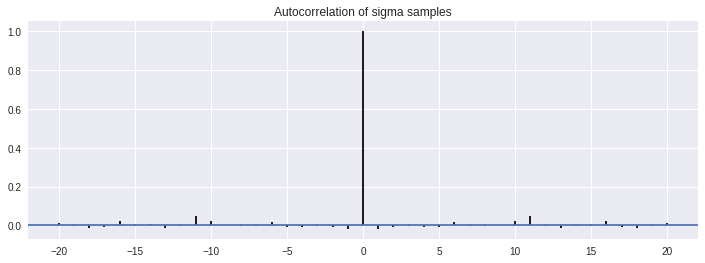

In [0]:
# Plot sample autocorrelation for each parameter.
# Code reference: 14.1 Preclass work 3

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

In [0]:
#Extract samples of predicted values
prediction = samples['x_future']
#Calculate the intervals and means of each days
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])
pred_mean = [pred.mean() for pred in np.transpose(prediction)]
len(pred_mean)

2080

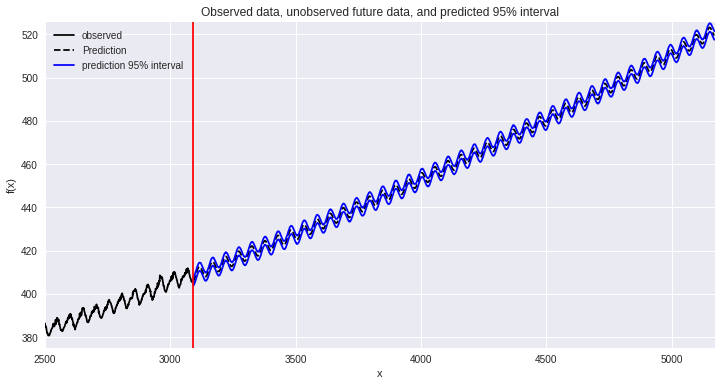

In [0]:
# Compute the mean and 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])
prediction_mean = [pred.mean() for pred in np.transpose(prediction)]

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, n + 1), data[:n, 1], 'k-', label='observed')
plt.plot(range(n, (n + n_future)), prediction_mean, 'k--', label='Prediction')

plt.xlim(2500, n + n_future + 1)
plt.ylim(375, max(max(prediction[1,:]), max(data[:, 1])))

plt.plot(
    range(n, n + n_future+1),
    np.concatenate((data[-1:,1], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(n, n + n_future+1),
    np.concatenate((data[-1:,1], prediction_interval[1,:])),
    'b-')
plt.axvline(n - 1, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [0]:
#Calculating CO2 Level at the start of 2058
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])
prediction_mean = [pred.mean() for pred in np.transpose(prediction)]

print(prediction_mean[-1])
print(prediction_interval[:,-1])

519.4727463980236
[517.53805061 521.44429646]


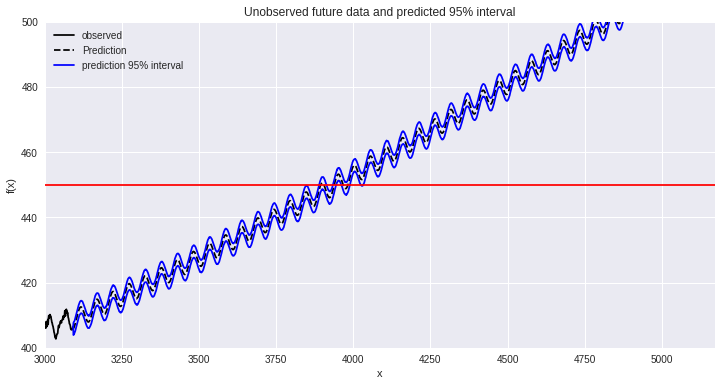

Estimated Year when C0_2 Level would be dangerous: 2034.041095890411


In [0]:
# Zoom in to the predictions
plt.figure(figsize=(12, 6))

plt.plot(range(1, n + 1), data[:n, 1], 'k-', label='observed')
plt.plot(range(n, n + n_future), prediction_mean, 'k--', label='Prediction')

plt.xlim(3000, n + n_future + 1)
plt.ylim(400, 500)
plt.plot(
    range(n, n + n_future+1),
    np.concatenate((data[-1:,1], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(n, n + n_future+1),
    np.concatenate((data[-1:,1], prediction_interval[1,:])),
    'b-')
plt.axhline(450, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Unobserved future data and predicted 95% interval')
plt.show()

preds = np.array(prediction_mean)
t_danger = np.where(preds > 450)[0][0]
year_danger = (t_danger*7 + t[-1])/365 + 1958
print("Estimated Year when C0_2 Level would be dangerous:", year_danger) 